In [51]:
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import pandas as pd 
import numpy as np
import random
import yaml
import shap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [52]:
import sys, yaml, keras
import multiprocessing as mp
#sys.path.insert(0, '/glade/work/cbecker/gecko-ml/')
import warnings
warnings.filterwarnings("ignore")
import copy
import optuna
import logging
import traceback

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from geckoml.models import DenseNeuralNetwork
from geckoml.data import *
#from geckoml.box import *
from geckoml.metrics import *
#from geckoml.callbacks import *

from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise, Activation, \
    Concatenate, BatchNormalization, LSTM, Conv1D, AveragePooling1D, MaxPooling1D, LeakyReLU, PReLU, ELU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K

In [53]:
# This is a tqdm that works with notebooks when using tqdm more than once 
from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

In [54]:
logger = logging.getLogger(__name__)

In [55]:
def box_val(mod, exps, num_timesteps, in_array, env_array, y_scaler, output_cols, out_val):
    
    # use initial condition @ t = 0 and get the first prediction
    pred_array = np.empty((len(exps), 1439, 3))
    pred = mod.predict(in_array[:, 0, :])
    pred_array[:, 0, :] = pred

    # use the first prediction to get the next, and so on for num_timesteps
    for i in tqdm(range(1, num_timesteps)):
        temperature = in_array[:, i, 3:4]
        static_env = env_array[:, -5:]
        new_input = np.block([pred, temperature, static_env])
        pred = mod(new_input, training=False)
        pred_array[:, i, :] = pred

    # loop over the batch to fill up results dict
    results_dict = {}
    for k, exp in enumerate(exps):
        results_dict[exp] = pd.DataFrame(y_scaler.inverse_transform(pred_array[k]), columns=output_cols[1:-1])
        results_dict[exp]['id'] = exp
        results_dict[exp]['Time [s]'] = out_val['Time [s]'].unique()
        results_dict[exp] = results_dict[exp].reindex(output_cols, axis=1)

    preds = pd.concat(results_dict.values())
    truth = out_val.loc[out_val['id'].isin(exps)]
    truth = truth.sort_values(['id', 'Time [s]']).reset_index(drop=True)
    preds = preds.sort_values(['id', 'Time [s]']).reset_index(drop=True)
    box_mae = mean_absolute_error(preds.iloc[:, 2:-1], truth.iloc[:, 2:-1])
    
    return box_mae

In [56]:
def box_val_shap(mod, exps, num_timesteps, in_array, env_array, y_scaler, output_cols, out_val):
    
    # use initial condition @ t = 0 and get the first prediction
    pred_array = np.empty((len(exps), 1439, 3))
    input_array = np.empty((len(exps), 1439, 9))
    pred = mod.predict(in_array[:, 0, :])
    input_array[:, 0, :] = in_array[:, 0, :]
    pred_array[:, 0, :] = pred

    # use the first prediction to get the next, and so on for num_timesteps
    for i in tqdm(range(1, num_timesteps)):
        temperature = in_array[:, i, 3:4]
        static_env = env_array[:, -5:]
        new_input = np.block([pred, temperature, static_env])
        pred = mod(new_input, training=False)
        pred_array[:, i, :] = pred
        input_array[:, i, :] = new_input
    
    return input_array, pred_array

In [57]:
with open("/glade/work/schreck/repos/gecko-ml/scripts/schreck/echo/model_config.yml") as config_file:
    conf = yaml.load(config_file, Loader=yaml.FullLoader)

In [58]:
tf.random.set_seed(5999)

scalers = {"MinMaxScaler": MinMaxScaler,
           "StandardScaler": StandardScaler}

species = conf['species']
dir_path = conf['dir_path']
summary_file = conf['summary_file']
aggregate_bins = conf['aggregate_bins']
bin_prefix = conf['bin_prefix']
input_vars = conf['input_vars']
output_vars = conf['output_vars']
scaler_type = conf['scaler_type']
exps = conf['box_val_exps']
output_cols = conf['output_vars']

# Load the data
in_train = pd.read_csv('/glade/scratch/cbecker/gecko_data/apin_O3_train_in_agg.csv')
out_train = pd.read_csv('/glade/scratch/cbecker/gecko_data/apin_O3_train_out_agg.csv')
in_val = pd.read_csv('/glade/scratch/cbecker/gecko_data/apin_O3_val_in_agg.csv')
out_val = pd.read_csv('/glade/scratch/cbecker/gecko_data/apin_O3_val_out_agg.csv')

num_timesteps = in_train['Time [s]'].nunique()

# Rescale training and validation / testing data
if scaler_type == "MinMaxScaler":
    x_scaler = scalers[scaler_type]((conf['min_scale_range'], conf['max_scale_range']))
else:
    x_scaler = scalers[scaler_type]()
scaled_in_train = x_scaler.fit_transform(in_train.drop(['Time [s]', 'id'], axis=1))
scaled_in_val = x_scaler.transform(in_val.drop(['Time [s]', 'id'], axis=1))

y_scaler = get_output_scaler(x_scaler, output_vars, scaler_type, data_range=(
    conf['min_scale_range'], conf['max_scale_range']))
scaled_out_train = y_scaler.transform(out_train.drop(['Time [s]', 'id'], axis=1))
scaled_out_val = y_scaler.transform(out_val.drop(['Time [s]', 'id'], axis=1))

y = partition_y_output(scaled_out_train, conf["dense_network"]['output_layers'], aggregate_bins)
y_val = partition_y_output(scaled_out_val, conf["dense_network"]['output_layers'], aggregate_bins)

In [59]:
def work(exp):
    in_data = x_scaler.transform(in_train[in_train['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))

# Train the model in box mode
train_exps = list(in_train['id'].unique())
pool = mp.Pool(processes=8)
in_array, env_array = zip(*[result for result in tqdm(pool.imap(work, train_exps), total = len(train_exps))])
pool.close()

in_array = np.concatenate(in_array) # (num_experiments, num_timesteps, outputs)
env_array = np.concatenate(env_array)

100%|██████████| 1600/1600 [00:25<00:00, 62.17it/s]


In [60]:
def work(exp):
    in_data = x_scaler.transform(in_val[in_val['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))

# Train the model in box mode
val_exps = list(in_val['id'].unique())
pool = mp.Pool(processes=8)
val_in_array, val_env_array = zip(*[result for result in tqdm(pool.imap(work, val_exps), total = len(val_exps))])
pool.close()

val_in_array = np.concatenate(val_in_array) # (num_experiments, num_timesteps, outputs)
val_env_array = np.concatenate(val_env_array)

100%|██████████| 200/200 [00:00<00:00, 387.88it/s]


In [61]:
# Load the model
mod = DenseNeuralNetwork(**conf["dense_network"])
inputs = scaled_in_train.shape[1]
outputs = [i.shape[-1] for i in y]
mod.build_neural_network(inputs, outputs)
mod.model.load_weights(f"/glade/work/schreck/repos/gecko-ml/scripts/schreck/echo/best_500.h5")
model = mod.model

In [62]:
box_mae = box_val(
    model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    y_scaler, 
    output_cols, 
    out_val
)

100%|██████████| 1438/1438 [00:02<00:00, 542.69it/s]


In [63]:
box_mae

0.002793755612622328

### Begin shap

In [69]:
background = shap.maskers.Independent(scaled_in_train[np.random.choice(scaled_in_train.shape[0], 1000, replace=False)])
explainer = shap.Explainer(model, background)

In [70]:
#scaled_in_val_sample = scaled_in_val[np.random.choice(scaled_in_val.shape[0], 1, replace=False)]
#shap_values = explainer(scaled_in_val_sample)

In [71]:
#shap_values.values[0]

In [72]:
#shap_values.base_values[0]

### Get the validation box input_data

In [73]:
_x, _y = box_val_shap(
    model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    y_scaler, 
    output_cols, 
    out_val
)

100%|██████████| 1438/1438 [00:02<00:00, 517.23it/s]


In [74]:
_x.shape

(200, 1439, 9)

In [75]:
class Experiment:
    
    def __init__(self, x, exp_id):
        self.x = x
        self.id = exp_id
    
    def work(self, t):
        return explainer(np.expand_dims(self.x[self.id][t], axis=0)).values

In [76]:
def results(experiment_id):
    
    exp = Experiment(_x, experiment_id)
    shap_results = [exp.work(t) for t in tqdm(range(_x.shape[1]))]
    
    pre = np.vstack([i.squeeze(0)[:,0] for i in shap_results])
    gas = np.vstack([i.squeeze(0)[:,1] for i in shap_results])
    air = np.vstack([i.squeeze(0)[:,2] for i in shap_results])
    
    plt.figure(figsize=(7,14))

    plt.subplot(311)
    leg = ['gas', 'aerosol', 'temperature', 'sza', 'pre-existing aerosol', 'ozone', 'nox', 'OH']
    for i in [1, 2, 3, 4, 5, 6, 7, 8]:
        plt.plot(range(1439), pre[:, i])
    plt.ylabel("Precursor SHAP", fontsize = 14)
    plt.legend(leg, fontsize = 12, ncol=2, loc = 'best')


    plt.subplot(312)
    leg = ['precursor', 'aerosol', 'temperature', 'sza', 'pre-existing aero', 'ozone', 'nox', 'OH']
    for i in [0, 2, 3, 4, 5, 6, 7, 8]:
        plt.plot(range(1439), gas[:, i])
    plt.ylabel("Gas SHAP", fontsize = 14)
    plt.legend(leg, fontsize = 12, ncol=2, loc = 'best')

    plt.subplot(313)
    leg = ['precursor', 'gas', 'temperature', 'sza', 'pre-existing aero', 'ozone', 'nox', 'OH']
    for i in [0, 1, 3, 4, 5, 6, 7, 8]:
        plt.plot(range(1439), air[:, i])
    plt.ylabel("Aerosol SHAP", fontsize = 14)
    plt.legend(leg, fontsize = 12, ncol=2, loc = 'best')

    plt.xlabel("Time (s)", fontsize = 14)

    plt.tight_layout()

    plt.savefig(f"images/alpha_pinene/alpha_pinene_validation_{experiment_id}.png")
    np.save(f"images/alpha_pinene/alpha_pinene_validation_{experiment_id}_pre.npy", pre)
    np.save(f"images/alpha_pinene/alpha_pinene_validation_{experiment_id}_gas.npy", gas)
    np.save(f"images/alpha_pinene/alpha_pinene_validation_{experiment_id}_aero.npy", air)

In [ ]:
results(1)

 45%|████▌     | 650/1439 [06:05<07:23,  1.78it/s]

In [22]:
exp = Experiment(_x, 0)
shap_results = [exp.work(t) for t in tqdm(range(_x.shape[1]-1))]

100%|██████████| 1438/1438 [12:02<00:00,  1.99it/s]


In [31]:
pre = [i.squeeze(0)[:,0] for i in shap_results]
gas = [i.squeeze(0)[:,1] for i in shap_results]
air = [i.squeeze(0)[:,2] for i in shap_results]

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [10]:
with open("test.pkl", "rb") as fid:
    pre,gas,air = pickle.load(fid)

In [11]:
pre = np.vstack(pre)
gas = np.vstack(gas)
air = np.vstack(air)

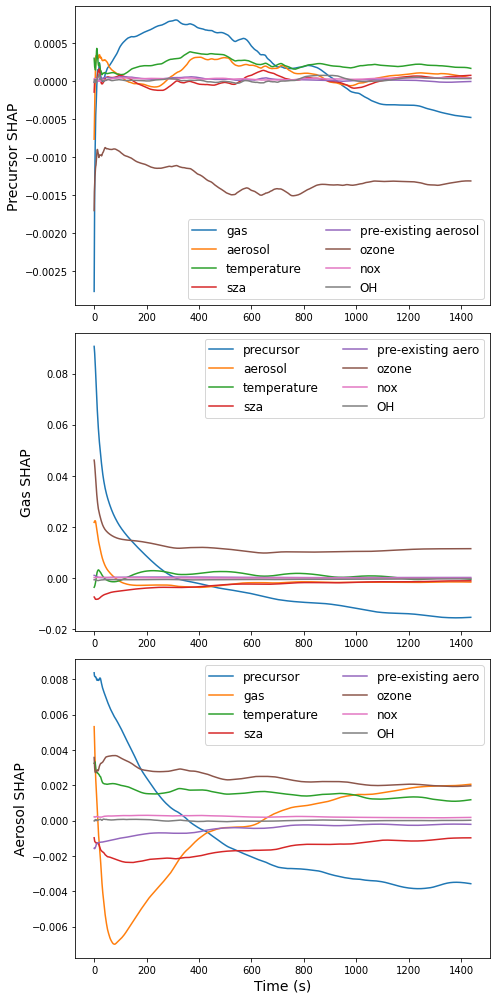

In [48]:
plt.figure(figsize=(7,14))

plt.subplot(311)
leg = ['gas', 'aerosol', 'temperature', 'sza', 'pre-existing aerosol', 'ozone', 'nox', 'OH']
for i in [1, 2, 3, 4, 5, 6, 7, 8]:
    plt.plot(range(1438), pre[:, i])
plt.ylabel("Precursor SHAP", fontsize = 14)
plt.legend(leg, fontsize = 12, ncol=2, loc = 'best')


plt.subplot(312)
leg = ['precursor', 'aerosol', 'temperature', 'sza', 'pre-existing aero', 'ozone', 'nox', 'OH']
for i in [0, 2, 3, 4, 5, 6, 7, 8]:
    plt.plot(range(1438), gas[:, i])
plt.ylabel("Gas SHAP", fontsize = 14)
plt.legend(leg, fontsize = 12, ncol=2, loc = 'best')

plt.subplot(313)
leg = ['precursor', 'gas', 'temperature', 'sza', 'pre-existing aero', 'ozone', 'nox', 'OH']
for i in [0, 1, 3, 4, 5, 6, 7, 8]:
    plt.plot(range(1438), air[:, i])
plt.ylabel("Aerosol SHAP", fontsize = 14)
plt.legend(leg, fontsize = 12, ncol=2, loc = 'best')

plt.xlabel("Time (s)", fontsize = 14)

plt.tight_layout()

plt.savefig(f"images/alpha_pinene/alpha_pinene_validation_{0}.png")